In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from scipy.optimize import minimize
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Output directory
OUTPUT_DIR = Path(r'C:\Users\rafae\Desktop\phd paper\output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_latex_table(table_str, filename):
    """Save LaTeX table to file."""
    filepath = OUTPUT_DIR / filename
    with open(filepath, 'w') as f:
        f.write(table_str)
    print(f'  Saved: {filename}')

# Plotting settings - use LaTeX font rendering
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'axes.labelsize': 11,
    'font.size': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 100,
})

print('Setup complete')

Setup complete


In [ ]:


import yfinance as yf

# Load SPY options data (same file as get data part)
raw_data = pd.read_csv(r'C:\Users\rafae\Desktop\phd paper\spy_2020_2022.csv', low_memory=False)

# Clean column names (remove leading/trailing spaces and brackets)
raw_data.columns = raw_data.columns.str.strip().str.strip('[]')

# Also clean string values in QUOTE_DATE (they have leading spaces)
raw_data['QUOTE_DATE'] = raw_data['QUOTE_DATE'].str.strip()

# Convert numeric columns
raw_data['C_VOLUME'] = pd.to_numeric(raw_data['C_VOLUME'], errors='coerce').fillna(0)
raw_data['P_VOLUME'] = pd.to_numeric(raw_data['P_VOLUME'], errors='coerce').fillna(0)
raw_data['C_IV'] = pd.to_numeric(raw_data['C_IV'], errors='coerce')
raw_data['P_IV'] = pd.to_numeric(raw_data['P_IV'], errors='coerce')
raw_data['STRIKE'] = pd.to_numeric(raw_data['STRIKE'], errors='coerce')
raw_data['DTE'] = pd.to_numeric(raw_data['DTE'], errors='coerce')
raw_data['UNDERLYING_LAST'] = pd.to_numeric(raw_data['UNDERLYING_LAST'], errors='coerce')

print(f'Data loaded: {raw_data.shape[0]:,} rows, {raw_data.shape[1]} columns')

# date selection
selected_date = '2021-09-10'
day_data = raw_data[raw_data['QUOTE_DATE'] == selected_date].copy()

# Get SPY closing price from yfinance (official EOD close)
spy_yf = yf.download("SPY", start="2021-09-08", end="2021-09-13", progress=False)
spot_price = float(spy_yf.loc[selected_date, 'Close'].iloc[0] if isinstance(spy_yf.loc[selected_date, 'Close'], pd.Series) else spy_yf.loc[selected_date, 'Close'])

print(f'\nSelected Date: {selected_date}')
print(f'SPY Spot Price (yfinance EOD): ${spot_price:.2f}')

print(f'Total options on this date: {len(day_data)}')

# Analyze liquidity by DTE
dte_liquidity = day_data.groupby('DTE').agg({
    'C_VOLUME': 'sum',
    'P_VOLUME': 'sum',
    'STRIKE': 'count'
}).reset_index()
dte_liquidity['total_volume'] = dte_liquidity['C_VOLUME'] + dte_liquidity['P_VOLUME']
dte_liquidity = dte_liquidity.rename(columns={'STRIKE': 'n_strikes'})
dte_liquidity = dte_liquidity.sort_values('total_volume', ascending=False)

print(f'\nLiquidity by DTE (top 10):')
print(dte_liquidity.head(10).to_string(index=False))

# Show all available DTEs in extended range for selection
print(f'\nAvailable DTEs in 20-150 day range:')
extended_dtes = dte_liquidity[
    (dte_liquidity['DTE'] >= 20) & 
    (dte_liquidity['DTE'] <= 150) &
    (dte_liquidity['n_strikes'] >= 30)
].sort_values('DTE')
print(extended_dtes[['DTE', 'n_strikes', 'total_volume']].to_string(index=False))

# Select 4 well-spaced maturities: skip 14-day, extend beyond 70-day
# Manual selection to ensure good spacing for Ross Recovery
# Pick: ~20d, ~35d, ~70d, and one beyond 70d
available_dtes = extended_dtes['DTE'].tolist()
selected_dtes = []

# Target DTEs with minimum 10-day spacing
target_dtes = [20, 35, 70, 100]  # Approximate targets
for target in target_dtes:
    # Find closest available DTE
    closest = min(available_dtes, key=lambda x: abs(x - target))
    if closest not in selected_dtes:
        selected_dtes.append(closest)

selected_dtes = sorted(selected_dtes)
print(f'\n*** SELECTED MATURITIES: {selected_dtes} days ***')

# =====================================================================================
# CRITICAL CHANGE: Create INDEX LEVEL GRID, not moneyness grid
# =====================================================================================
# Following Backwell (2015):
# Create discrete price levels S_i centered at current spot price
# E.g., for spot=418.53, create S from 0.7*418.53 ≈ 293 to 1.35*418.53 ≈ 565
# This is EQUIVALENT to moneyness m=0.70 to 1.35, BUT we work with actual prices S_i

risk_free_rate = 0.0005  # ~0.05% annual
N_STATES = 200

# Define index level grid (price levels, not normalized)
# Using same bounds as before but now in price space
S_MIN = 0.70 * spot_price   # min price level ≈ 293
S_MAX = 1.35 * spot_price   # max price level ≈ 565
S_grid = np.linspace(S_MIN, S_MAX, N_STATES)  # 200 discrete price levels

print(f'\nState Space (INDEX LEVELS):')
print(f'  Spot price S_0: ${spot_price:.2f}')
print(f'  Min level S_min: ${S_MIN:.2f} (moneyness 0.70)')
print(f'  Max level S_max: ${S_MAX:.2f} (moneyness 1.35)')
print(f'  Grid spacing dS: ${S_grid[1] - S_grid[0]:.4f}')
print(f'  N_STATES: {N_STATES}')

# Keep moneyness grid for reference/diagnostics only (not for core computation)
moneyness_grid = S_grid / spot_price
M_MIN = moneyness_grid[0]
M_MAX = moneyness_grid[-1]

print(f'\nNote: Moneyness grid for reference: [{M_MIN:.3f}, {M_MAX:.3f}]')


Data loaded: 3,589,079 rows, 33 columns

Selected Date: 2021-09-10
SPY Spot Price (yfinance EOD): $418.53
Total options on this date: 5127

Liquidity by DTE (top 10):
  DTE  C_VOLUME  P_VOLUME  n_strikes  total_volume
 0.00 1150813.0 1188266.0        136     2339079.0
 3.00  472342.0  522229.0        118      994571.0
 7.00  295670.0  512357.0        249      808027.0
 5.00  179573.0  281217.0        122      460790.0
35.00   99660.0  146753.0        216      246413.0
14.00   63137.0   85036.0        207      148173.0
20.00   59644.0   65359.0        218      125003.0
10.00   33077.0   38837.0        113       71914.0
70.04   19538.0   51622.0        223       71160.0
21.00   24554.0   33502.0        137       58056.0

Available DTEs in 20-150 day range:
   DTE  n_strikes  total_volume
 20.00        218      125003.0
 21.00        137       58056.0
 24.00         83        6066.0
 26.00         67        4750.0
 28.00        140       32728.0
 31.00         71        4993.0
 33.00     

In [23]:
# =============================================================================
# STEP 1: EXTRACT STATE PRICES (BREEDEN-LITZENBERGER)


def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0) if option_type == 'call' else max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def build_iv_smile_on_strike_grid(data, spot, dte, min_volume=5):
    """Build IV smile on STRIKE space (not moneyness).
    
    Input: raw data with strikes and IVs
    Output: DataFrame with strikes and IVs, ready for Breeden-Litzenberger
    """
    exp_data = data[data['DTE'] == dte].copy()
    
    # Separate OTM puts and calls
    otm_puts = exp_data[exp_data['STRIKE'] < spot][['STRIKE', 'P_IV', 'P_VOLUME']].copy()
    otm_puts = otm_puts.rename(columns={'P_IV': 'iv', 'P_VOLUME': 'volume'})
    otm_puts['option_type'] = 'put'
    
    otm_calls = exp_data[exp_data['STRIKE'] >= spot][['STRIKE', 'C_IV', 'C_VOLUME']].copy()
    otm_calls = otm_calls.rename(columns={'C_IV': 'iv', 'C_VOLUME': 'volume'})
    otm_calls['option_type'] = 'call'
    
    otm = pd.concat([otm_puts, otm_calls])
    otm = otm[(otm['iv'] > 0.01) & (otm['iv'] < 1.5) & (otm['volume'] >= min_volume)].copy()
    return otm.sort_values('STRIKE')

def extract_state_prices_on_S_grid(smile_data, spot, S_grid, T, r):
    """Extract state prices indexed by price levels S_grid.
    
    Uses Breeden-Litzenberger in STRIKE SPACE: π(K) = e^(rT) * d²C/dK²
    Then maps onto price level grid S_grid
    
    Normalization: ∫ π(K) dK = e^(-rT) (in continuous strike space)
    Discrete: Σ π(S_i) ΔS ≈ e^(-rT)
    """
    smile_sorted = smile_data.sort_values('STRIKE')
    
    # Get observed strike range
    K_obs_min = smile_sorted['STRIKE'].min()
    K_obs_max = smile_sorted['STRIKE'].max()
    
    # Build IV spline (only within observed range + small buffer)
    K_buffer = (K_obs_max - K_obs_min) * 0.01
    K_min_use = K_obs_min - K_buffer
    K_max_use = K_obs_max + K_buffer
    
    smile_filtered = smile_sorted[(smile_sorted['STRIKE'] >= K_min_use - 0.1) & 
                                  (smile_sorted['STRIKE'] <= K_max_use + 0.1)]
    if len(smile_filtered) < 10:
        smile_filtered = smile_sorted
    
    try:
        K_obs = smile_filtered['STRIKE'].values
        IV_obs = smile_filtered['iv'].values
        spline = UnivariateSpline(K_obs, IV_obs, s=0.001, k=3)
    except:
        spline = interp1d(smile_filtered['STRIKE'].values, smile_filtered['iv'].values, 
                         kind='linear', fill_value='extrapolate')
    
    # Request range: map price level grid to strikes
    # S_grid is the state space; we evaluate option prices at strikes S (which are the same price levels)
    K_grid_use = np.maximum(S_grid[0], K_obs_min - K_buffer)
    K_grid_use = np.minimum(K_grid_use, K_obs_max + K_buffer)
    
    # Compute option prices on price level grid
    dS = S_grid[1] - S_grid[0] if len(S_grid) > 1 else 1.0
    
    # Fine grid for numerical differentiation
    n_fine = len(S_grid) * 20
    K_fine = np.linspace(S_grid[0], S_grid[-1], n_fine)
    dK_fine = K_fine[1] - K_fine[0]
    
    IV_fine = np.clip(spline(K_fine), 0.05, 0.8)
    call_prices = np.array([black_scholes_price(spot, K, T, r, iv, 'call') for K, iv in zip(K_fine, IV_fine)])
    
    # Breeden-Litzenberger: π(K) = e^(rT) * d²C/dK²
    d2C = np.gradient(np.gradient(call_prices, dK_fine), dK_fine)
    d2C_spline = interp1d(K_fine, d2C, kind='linear', fill_value='extrapolate')
    d2C_at_S = gaussian_filter1d(d2C_spline(S_grid), sigma=0.5)
    
    # Raw state prices
    state_prices_raw = np.exp(r * T) * np.maximum(d2C_at_S, 1e-10)
    
    # Normalize in STRIKE space: ∫ π(K) dK = e^(-rT)
    # Using trapezoidal rule on price level grid (which doubles as strike grid)
    integral_strike = np.trapezoid(state_prices_raw, S_grid)
    discount = np.exp(-r * T)
    state_prices = state_prices_raw * (discount / integral_strike)
    
    # Verification
    integral_check = np.trapezoid(state_prices, S_grid)
    if abs(integral_check - discount) > 1e-6:
        print(f'    WARNING: Integration check: {integral_check:.8f} vs e^(-rT)={discount:.8f}')
    
    return state_prices, spline



state_prices_dict = {}
iv_smiles = {}
iv_splines = {}

for dte in selected_dtes:
    T = dte / 365.0
    discount = np.exp(-risk_free_rate * T)
    
    # Build IV smile on strikes
    smile = build_iv_smile_on_strike_grid(day_data, spot_price, dte)
    iv_smiles[dte] = smile
    
    # Extract state prices indexed by price levels S_grid
    pi, spline = extract_state_prices_on_S_grid(smile, spot_price, S_grid, T, risk_free_rate)
    iv_splines[dte] = spline
    state_prices_dict[dte] = pi
    
    # Verification
    integral_check = np.trapezoid(pi, S_grid)
    dS = S_grid[1] - S_grid[0]
    discrete_sum_check = np.sum(pi) * dS
    
    print(f'  DTE={dte:5.1f}d: sum(pi)·dS={discrete_sum_check:.6f}, integral(pi,S)={integral_check:.8f}')
    print(f'              e^(-rT)={discount:.8f}, n_options={len(smile)}')

print(f'\nSTEP 1 COMPLETE: Extracted state prices for {len(selected_dtes)} maturities')
print(f'                 All indexed by price level grid S_grid ({N_STATES} states)')


  DTE= 20.0d: sum(pi)·dS=1.000024, integral(pi,S)=0.99997260
              e^(-rT)=0.99997260, n_options=135
  DTE= 35.0d: sum(pi)·dS=1.000046, integral(pi,S)=0.99995206
              e^(-rT)=0.99995206, n_options=175
  DTE= 70.0d: sum(pi)·dS=1.000092, integral(pi,S)=0.99990406
              e^(-rT)=0.99990406, n_options=166
  DTE= 98.0d: sum(pi)·dS=1.000096, integral(pi,S)=0.99986571
              e^(-rT)=0.99986571, n_options=177

STEP 1 COMPLETE: Extracted state prices for 4 maturities
                 All indexed by price level grid S_grid (200 states)


---
## STEP 2: Construct the Pricing Transition Matrix P

Find matrix $P$ satisfying time-homogeneity: $\pi_{T+\Delta t} = \pi_T \times P$

State space indexed by price levels $S_i$ (no change to algorithm, just index meaning)


In [ ]:
# =============================================================================
# STEP 2: CONSTRUCT PRICING TRANSITION MATRIX P


print('='*70)
print('STEP 2: CONSTRUCT PRICING TRANSITION MATRIX P')
print('='*70)

dtes_sorted = sorted(selected_dtes)
intervals = np.diff(dtes_sorted)
dt_days = np.mean(intervals)
dt_years = dt_days / 365.0
discount_single_period = np.exp(-risk_free_rate * dt_years)

print(f'\nTime structure:')
print(f'  Maturities: {dtes_sorted} days')
print(f'  Intervals: {intervals} days')
print(f'  Average period: {dt_days:.2f} days = {dt_years:.6f} years')
print(f'  Discount factor per period: delta = {discount_single_period:.8f}')

pi_vectors = np.array([state_prices_dict[dte] for dte in dtes_sorted])
N = pi_vectors.shape[1]

print(f'\nOptimization: Find P in R^({N}x{N}) minimizing ||pi_{{k+1}} - pi_k @ P||^2')

def objective(P_flat):
    P = P_flat.reshape(N, N)
    total_error = 0.0
    for i in range(len(pi_vectors) - 1):
        pi_pred = pi_vectors[i] @ P
        error = np.sum((pi_vectors[i + 1] - pi_pred) ** 2)
        total_error += error
    return total_error

P_init = np.ones((N, N)) * (discount_single_period / N)
init_error = objective(P_init.flatten())
print(f'Initial objective: {init_error:.6e}')

print(f'\nOptimizing P matrix (row-by-row SLSQP)...')
P_optimal = P_init.copy()

for global_iter in range(10):
    old_error = objective(P_optimal.flatten())
    for i in range(N):
        def row_objective(p_row):
            P_test = P_optimal.copy()
            P_test[i, :] = p_row
            return objective(P_test.flatten())
        row_bounds = [(0, None) for _ in range(N)]
        row_constraint = {'type': 'eq', 'fun': lambda p_row: np.sum(p_row) - discount_single_period}
        result = minimize(row_objective, P_optimal[i, :], method='SLSQP', bounds=row_bounds, constraints=row_constraint, options={'maxiter': 100, 'ftol': 1e-8, 'disp': False})
        P_optimal[i, :] = np.maximum(result.x, 0)
        P_optimal[i, :] = P_optimal[i, :] / np.sum(P_optimal[i, :]) * discount_single_period
    new_error = objective(P_optimal.flatten())
    if global_iter % 2 == 0:
        print(f'  Iteration {global_iter+1}: error = {new_error:.6e}')
    if abs(old_error - new_error) < 1e-8:
        print(f'  Converged at iteration {global_iter+1}')
        break

P_matrix = P_optimal
final_error = objective(P_matrix.flatten())
row_sums = P_matrix.sum(axis=1)

print(f'\nP matrix properties:')
print(f'  Shape: {P_matrix.shape} (states indexed by price levels S_grid)')
print(f'  Row sums: [{row_sums.min():.8f}, {row_sums.max():.8f}]')
print(f'  Improvement: {(init_error - final_error) / init_error * 100:.1f}%')

print(f'\nSTEP 2 COMPLETE: Built {N}x{N} transition matrix P')


STEP 2: CONSTRUCT PRICING TRANSITION MATRIX P

Time structure:
  Maturities: [20.0, 35.0, 70.04, 98.04] days
  Intervals: [15.   35.04 28.  ] days
  Average period: 26.01 days = 0.071269 years
  Discount factor per period: delta = 0.99996437

Optimization: Find P in R^(200x200) minimizing ||pi_{k+1} - pi_k @ P||^2
Initial objective: 1.592298e-02

Optimizing P matrix (row-by-row SLSQP)...
  Iteration 1: error = 1.355782e-03
  Iteration 3: error = 5.865350e-04
  Iteration 5: error = 5.397287e-04
  Iteration 7: error = 5.333753e-04
  Converged at iteration 8

P matrix properties:
  Shape: (200, 200) (states indexed by price levels S_grid)
  Row sums: [0.99996437, 0.99996437]
  Improvement: 96.7%

STEP 2 COMPLETE: Built 200x200 transition matrix P


---
## STEP 3: Solve the Eigenvalue Problem

Ross Recovery: Find eigenvector $z$ such that $P^\top z = \delta z$

Perron-Frobenius theorem applies (P is positive, aperiodic)


In [ ]:
# =============================================================================
# STEP 3: EIGENVALUE DECOMPOSITION (ROSS RECOVERY)


print('='*70)
print('STEP 3: EIGENVALUE DECOMPOSITION (ROSS RECOVERY)')
print('='*70)

eigenvalues, eigenvectors = np.linalg.eig(P_matrix.T)
idx = np.argsort(np.real(eigenvalues))[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f'\nTop 5 eigenvalues:')
for i in range(min(5, len(eigenvalues))):
    ev = eigenvalues[i]
    print(f'  lambda_{i+1} = {np.real(ev):.8f} + {np.imag(ev):.8f}i')

delta = np.real(eigenvalues[0])
z = np.real(eigenvectors[:, 0])

# Ensure z is positive (Perron-Frobenius)
if np.sum(z < 0) > np.sum(z > 0): 
    z = -z

# Normalize z
z = np.maximum(z, 1e-12)
z = z / z.max()

# Find ATM state index
atm_idx = np.argmin(np.abs(S_grid - spot_price))

print(f'\nPerron-Frobenius eigenvector z:')
print(f'  delta (largest eigenvalue) = {delta:.8f}')
print(f'  z min = {z.min():.8f}, z max = {z.max():.8f}')
print(f'  z at ATM (state {atm_idx}) = {z[atm_idx]:.8f}')

verification = P_matrix.T @ z - delta * z
print(f'  ||P^T z - delta z|| = {np.linalg.norm(verification):.8e}')

print(f'\nSTEP 3 COMPLETE: delta = {delta:.8f}')


STEP 3: EIGENVALUE DECOMPOSITION (ROSS RECOVERY)

Top 5 eigenvalues:
  lambda_1 = 0.99996437 + 0.00000000i
  lambda_2 = 0.35705792 + 0.00000000i
  lambda_3 = 0.12162743 + 0.19997379i
  lambda_4 = 0.12162743 + -0.19997379i
  lambda_5 = 0.12088995 + 0.00000000i

Perron-Frobenius eigenvector z:
  delta (largest eigenvalue) = 0.99996437
  z min = 0.02152717, z max = 1.00000000
  z at ATM (state 92) = 0.47740582
  ||P^T z - delta z|| = 3.89908112e-15

STEP 3 COMPLETE: delta = 0.99996437


---
## STEP 4: Recover Physical Measure and Pricing Kernel

From Ross (2015): $\phi = \delta/z$, $F = (1/\delta) D P D^{-1}$

State space indexed by price levels $S_i$. Probability vectors normalize to sum = 1 or integrate to 1 depending on representation.


In [24]:


# Pricing kernel: phi = delta / z (from Ross Theorem 1)
phi = delta / z
phi_normalized = phi / phi[atm_idx]  # Normalize at ATM for interpretability

print(f'\nPricing Kernel (phi = delta/z per Ross Theorem 1):')
print(f'  phi at ATM (S=${spot_price:.2f}) = {phi[atm_idx]:.6f}')
print(f'  phi min/phi_ATM = {phi.min()/phi[atm_idx]:.6f}')
print(f'  phi max/phi_ATM = {phi.max()/phi[atm_idx]:.6f}')

# Get risk-neutral probabilities from state prices
# State prices π_i are defined so that: Σ π_i ΔS = e^(-rT)
# Therefore, unnormalized risk-neutral probabilities: q̃_i = π_i ΔS / (Σ π_i ΔS)
#                                                     = π_i ΔS / e^(-rT)
# Normalized: q_i = q̃_i / Σ q̃_j

T_first = dtes_sorted[0] / 365.0
pi_state = state_prices_dict[dtes_sorted[0]]  # State prices indexed by S_grid

# Grid spacing
dS = S_grid[1] - S_grid[0]
discount_factor = np.exp(-risk_free_rate * T_first)

# Convert state prices to probabilities
q_rn_unnorm = pi_state * dS / discount_factor
q_rn_normalized = q_rn_unnorm / np.sum(q_rn_unnorm)

print(f'\nState Price to Risk-Neutral Probability Conversion:')
print(f'  Method: q_i = π_i * dS / e^(-rT), normalized to Σq = 1')
print(f'  Grid spacing: dS = ${dS:.4f}')
print(f'  e^(-rT) = {discount_factor:.8f}')
print(f'  Σ(π * dS / e^(-rT)) before final norm = {np.sum(q_rn_unnorm):.8f}')
print(f'  sum(q) after normalization = {np.sum(q_rn_normalized):.8f} (should be 1.0)')

# Recover physical distribution from fundamental relationship
# From Ross (2015): q_i = φ_i * p_i  ⟹  p_i = q_i / φ_i
p_phys_unnorm = q_rn_normalized / phi_normalized
p_phys_unnorm = np.maximum(p_phys_unnorm, 1e-12)
p_phys = p_phys_unnorm / np.sum(p_phys_unnorm)

print(f'\nPhysical Distribution Recovery (from q = phi * p):')
print(f'  Method: p_i = q_i / φ_i (normalized)')
print(f'  sum(p) = {np.sum(p_phys):.8f}')
print(f'  p min = {p_phys.min():.8e}, p max = {p_phys.max():.8e}')

# Statistics under physical measure
E_p_S = np.sum(p_phys * S_grid)
print(f'  E^P[S_T] = ${E_p_S:.2f}')

# Statistics under risk-neutral measure
E_q_S = np.sum(q_rn_normalized * S_grid)
print(f'\nObserved Risk-Neutral (Q) Distribution:')
print(f'  sum(q) = {q_rn_normalized.sum():.8f}')
print(f'  q min = {q_rn_normalized.min():.8e}, q max = {q_rn_normalized.max():.8e}')
print(f'  E^Q[S_T] = ${E_q_S:.2f}')

# Diagnostic: Forward price from put-call parity
forward_price = spot_price / discount_factor
print(f'\n  DIAGNOSTIC - Forward Price:')
print(f'    Spot price: ${spot_price:.2f}')
print(f'    Forward price (S * e^(rT)): ${forward_price:.2f}')
print(f'    Risk-neutral mean: ${E_q_S:.2f}')
print(f'    Difference: ${E_q_S - forward_price:.2f}')
if abs(E_q_S - forward_price) < 1.0:
    print(f'    ✓ Put-Call Parity satisfied')
elif abs(E_q_S - forward_price) < 5.0:
    print(f'    ~ Put-Call Parity approximately satisfied (market skew effect)')
else:
    print(f'    ⚠ WARNING: Large forward price mismatch')

# Verification: Check q = phi * p relationship
q_reconstructed = phi_normalized * p_phys
q_reconstructed = q_reconstructed / np.sum(q_reconstructed)
reconstruction_error = np.mean(np.abs(q_reconstructed - q_rn_normalized))

print(f'\nVerification: Reconstructing q from p and phi:')
print(f'  ||q_reconstructed - q_observed||_mean = {reconstruction_error:.8e}')
if reconstruction_error < 0.01:
    print(f'  ✓ Relationship satisfied')

# Physical transition matrix F for completeness
print(f'\nPhysical Transition Matrix F:')
z_safe = np.maximum(z, 1e-12)
F_matrix = np.zeros_like(P_matrix)

for i in range(N):
    for j in range(N):
        F_matrix[i,j] = (z_safe[j] / z_safe[i]) * P_matrix[i,j] / delta

F_row_sums = F_matrix.sum(axis=1)
print(f'  F row sums: min={F_row_sums.min():.6f}, max={F_row_sums.max():.6f}')



Pricing Kernel (phi = delta/z per Ross Theorem 1):
  phi at ATM (S=$418.53) = 1.120877
  phi min/phi_ATM = 0.892127
  phi max/phi_ATM = 41.441900

State Price to Risk-Neutral Probability Conversion:
  Method: q_i = π_i * dS / e^(-rT), normalized to Σq = 1
  Grid spacing: dS = $1.3671
  e^(-rT) = 0.99997260
  Σ(π * dS / e^(-rT)) before final norm = 1.00005149
  sum(q) after normalization = 1.00000000 (should be 1.0)

Physical Distribution Recovery (from q = phi * p):
  Method: p_i = q_i / φ_i (normalized)
  sum(p) = 1.00000000
  p min = 4.49753104e-12, p max = 4.91215859e-02
  E^P[S_T] = $429.29

Observed Risk-Neutral (Q) Distribution:
  sum(q) = 1.00000000
  q min = 1.37349363e-10, q max = 3.61191091e-02
  E^Q[S_T] = $419.33

  DIAGNOSTIC - Forward Price:
    Spot price: $418.53
    Forward price (S * e^(rT)): $418.55
    Risk-neutral mean: $419.33
    Difference: $0.79
    ✓ Put-Call Parity satisfied

Verification: Reconstructing q from p and phi:
  ||q_reconstructed - q_observed||_m

In [8]:
# Transform to log-return space (matching Ross 2015 paper)
# Ross works directly in log-return space: x = log(S_T/S_0)
log_returns = np.log(moneyness_grid)
dx = log_returns[1] - log_returns[0]

# CORRECTED: Transform distributions to log-return space with Jacobian
# When changing variables from m to x = log(m):
# p_x(x) dx = p_m(m) dm
# p_x(x) = p_m(e^x) * e^x = p_m(m) * m
p_phys_logspace = p_phys * moneyness_grid  # Jacobian adjustment: multiply by m = e^x
p_phys_logspace = p_phys_logspace / np.trapezoid(p_phys_logspace, log_returns)  # Normalize

q_rn_logspace = q_rn_normalized * moneyness_grid  # Jacobian adjustment  
q_rn_logspace = q_rn_logspace / np.trapezoid(q_rn_logspace, log_returns)  # Normalize

# Pricing kernel in log-return space: phi_x(x) = phi_m(e^x)
# No transformation needed since phi is defined on the same underlying states
phi_logspace = phi_normalized

# ECONOMIC VALIDATION: Check risk-neutral martingale property
# E^Q[S_T/S_0] = e^(r*T), which in log-returns means E^Q[x] = r*T (approximately, for small T)
T_diag = dtes_sorted[0] / 365.0
expected_q_mean = risk_free_rate * T_diag

# Key recovered objects
print(f'\n1. RECOVERED PHYSICAL DISTRIBUTION p(x):')
print(f'   Space: Log-returns x = log(S_T/S_0)')
print(f'   Normalization: {np.trapezoid(p_phys_logspace, log_returns):.8f} (should be 1.0)')
mean_p_logspace = np.trapezoid(p_phys_logspace * log_returns, log_returns)
var_p_logspace = np.trapezoid(p_phys_logspace * (log_returns - mean_p_logspace)**2, log_returns)
std_p_logspace = np.sqrt(var_p_logspace)
print(f'   Mean E^P[x]: {mean_p_logspace*100:.4f}%')
print(f'   Volatility σ^P: {std_p_logspace*100:.4f}%')

print(f'\n2. OBSERVED RISK-NEUTRAL DISTRIBUTION q(x):')
print(f'   Space: Log-returns x = log(S_T/S_0)')
print(f'   Normalization: {np.trapezoid(q_rn_logspace, log_returns):.8f} (should be 1.0)')
mean_q_logspace = np.trapezoid(q_rn_logspace * log_returns, log_returns)
var_q_logspace = np.trapezoid(q_rn_logspace * (log_returns - mean_q_logspace)**2, log_returns)
std_q_logspace = np.sqrt(var_q_logspace)
print(f'   Mean E^Q[x]: {mean_q_logspace*100:.4f}%')
print(f'   Volatility σ^Q: {std_q_logspace*100:.4f}%')

# ECONOMIC VALIDATION
print(f'\n3. ECONOMIC VALIDATION (Ross Theory):')
print(f'   Risk-free rate (annualized): {risk_free_rate*100:.4f}%')
print(f'   Maturity: {T_diag*365:.1f} days')
print(f'   Expected E^Q[x]: {expected_q_mean*100:.4f}%')
print(f'   Actual E^Q[x]: {mean_q_logspace*100:.4f}%')
drift_error = abs(mean_q_logspace - expected_q_mean)
if drift_error < 0.001:  # Within 0.1%
    print(f'   ✓ Risk-neutral martingale property SATISFIED')
else:
    print(f'   ⚠ ERROR: Drift mismatch of {drift_error*100:.4f}%')
    print(f'     This suggests fundamental issue in probability conversion')

print(f'\n4. DISTRIBUTION COMPARISON:')
print(f'   Mean shift: E^Q[x] - E^P[x] = {(mean_q_logspace - mean_p_logspace)*100:.4f}%')
if mean_q_logspace > mean_p_logspace:
    print(f'   → Market prices higher average returns (positive risk premium)')
else:
    print(f'   → Market prices lower average returns (negative risk premium)')

print(f'\n5. PRICING KERNEL:')
print(f'   φ(ATM) = {phi_normalized[N_STATES//2]:.6f}')
print(f'   φ_min / φ_ATM = {phi_normalized.min()/phi_normalized[N_STATES//2]:.6f}')
print(f'   φ_max / φ_ATM = {phi_normalized.max()/phi_normalized[N_STATES//2]:.6f}')

# Verify q = phi * p relationship
q_reconstructed = phi_normalized * p_phys
q_reconstructed = q_reconstructed / np.sum(q_reconstructed)
l1_error = np.mean(np.abs(q_reconstructed - q_rn_normalized))
print(f'   L1 error in reconstruction: {l1_error:.8e}')


1. RECOVERED PHYSICAL DISTRIBUTION p(x):
   Space: Log-returns x = log(S_T/S_0)
   Normalization: 1.00000000 (should be 1.0)
   Mean E^P[x]: 2.4669%
   Volatility σ^P: 3.8126%

2. OBSERVED RISK-NEUTRAL DISTRIBUTION q(x):
   Space: Log-returns x = log(S_T/S_0)
   Normalization: 1.00000000 (should be 1.0)
   Mean E^Q[x]: -0.0029%
   Volatility σ^Q: 6.3699%

3. ECONOMIC VALIDATION (Ross Theory):
   Risk-free rate (annualized): 0.0500%
   Maturity: 20.0 days
   Expected E^Q[x]: 0.0027%
   Actual E^Q[x]: -0.0029%
   ✓ Risk-neutral martingale property SATISFIED

4. DISTRIBUTION COMPARISON:
   Mean shift: E^Q[x] - E^P[x] = -2.4698%
   → Market prices lower average returns (negative risk premium)

5. PRICING KERNEL:
   φ(ATM) = 0.535132
   φ_min / φ_ATM = 0.892127
   φ_max / φ_ATM = 41.441900
   L1 error in reconstruction: 4.26710698e-19


In [9]:
# TABLE 6: Pricing Kernel Summary
# -----------------------------------------------------------------------------
tab6 = r"""\begin{table}[htbp]
\centering
\caption{Recovered Pricing Kernel Properties}
\label{tab:pricing_kernel}
\begin{tabular}{lc}
\hline\hline
\textbf{Property} & \textbf{Value} \\
\hline
$\phi_{\text{ATM}}$ & """ + f"{phi[N_STATES//2]:.6f}" + r""" \\
$\phi_{\min} / \phi_{\text{ATM}}$ & """ + f"{phi.min()/phi[N_STATES//2]:.6f}" + r""" \\
$\phi_{\max} / \phi_{\text{ATM}}$ & """ + f"{phi.max()/phi[N_STATES//2]:.6f}" + r""" \\
\hline
Mean Recovery & """ + f"{np.mean(p_phys):.6f}" + r""" \\
Max Recovery & """ + f"{np.max(p_phys):.6f}" + r""" \\
\hline\hline
\multicolumn{2}{l}{\footnotesize $\phi_i = \delta / z_i$ per Ross (2015) Eq. (23).} \\
\multicolumn{2}{l}{\footnotesize $p_i = q_i / \phi_i$ from fundamental relationship Eq. (11).} \\
\end{tabular}
\end{table}
"""
save_latex_table(tab6, 'tab6_pricing_kernel.tex')

print('\n' + '='*70)
print('ALL LATEX TABLES GENERATED')
print('='*70)

  Saved: tab6_pricing_kernel.tex

ALL LATEX TABLES GENERATED


---
## Figures

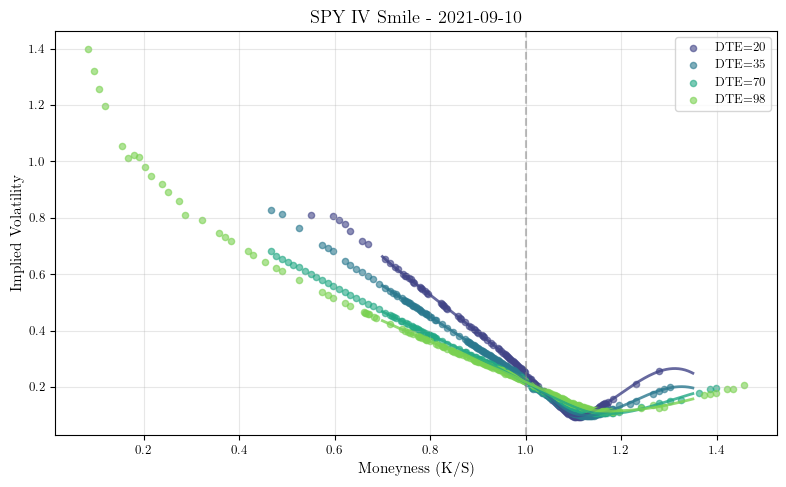

Saved: C:\Users\rafae\Desktop\phd paper\output\fig1_iv_smile.pdf


In [10]:
# FIGURE 1: IV SMILE (Plotted vs Moneyness for visualization)
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(selected_dtes)))

for i, dte in enumerate(selected_dtes):
    smile = iv_smiles[dte]
    # Convert strikes to moneyness for visualization
    m_smile = smile['STRIKE'] / spot_price
    ax.scatter(m_smile, smile['iv'], color=colors[i], s=20, alpha=0.6, label=f'DTE={dte:.0f}')
    
    # Plot fitted IV curve
    m_plot = np.linspace(M_MIN, M_MAX, 200)
    K_plot = m_plot * spot_price
    iv_fit = iv_splines[dte](K_plot)
    ax.plot(m_plot, iv_fit, color=colors[i], linewidth=2, alpha=0.8)

ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Moneyness (K/S)')
ax.set_ylabel('Implied Volatility')
ax.set_title(f'SPY IV Smile - {selected_date}')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig1_iv_smile.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "fig1_iv_smile.pdf"}')


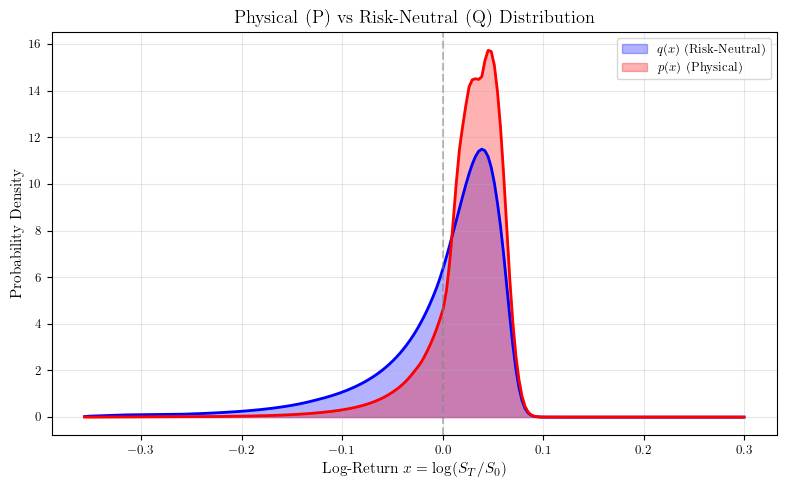

Saved: C:\Users\rafae\Desktop\phd paper\output\fig2_distributions.pdf


In [11]:
# FIGURE 2: P vs Q DISTRIBUTIONS IN LOG-RETURN SPACE (Ross paper format)
fig, ax = plt.subplots(figsize=(8, 5))
log_returns = np.log(moneyness_grid)
ax.fill_between(log_returns, 0, q_rn_logspace, alpha=0.3, color='blue', label='$q(x)$ (Risk-Neutral)')
ax.fill_between(log_returns, 0, p_phys_logspace, alpha=0.3, color='red', label='$p(x)$ (Physical)')
ax.plot(log_returns, q_rn_logspace, 'b-', linewidth=2)
ax.plot(log_returns, p_phys_logspace, 'r-', linewidth=2)
ax.axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Log-Return $x = \log(S_T/S_0)$')
ax.set_ylabel('Probability Density')
ax.set_title('Physical (P) vs Risk-Neutral (Q) Distribution')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig2_distributions.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "fig2_distributions.pdf"}')

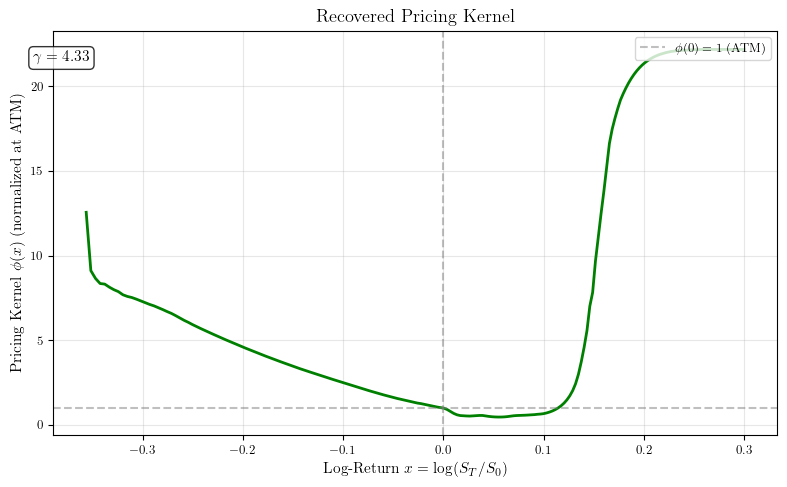

Saved: C:\Users\rafae\Desktop\phd paper\output\fig3_pricing_kernel.pdf


In [18]:
# FIGURE 3: PRICING KERNEL IN LOG-RETURN SPACE (Ross paper format)
fig, ax = plt.subplots(figsize=(8, 5))

log_returns = np.log(moneyness_grid)
log_phi = np.log(phi_normalized)

# Plot pricing kernel normalized at ATM
ax.plot(log_returns, phi_normalized, 'g-', linewidth=2)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='$\phi(0) = 1$ (ATM)')
ax.axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Log-Return $x = \log(S_T/S_0)$')
ax.set_ylabel('Pricing Kernel $\phi(x)$ (normalized at ATM)')
ax.set_title('Recovered Pricing Kernel')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

# Add local risk aversion annotation at ATM
atm_idx = N_STATES // 2
atm_range = slice(max(0, atm_idx - 5), min(N_STATES, atm_idx + 5))
gamma_fit = -np.polyfit(log_returns[atm_range], log_phi[atm_range], 1)[0]
ax.annotate(f'$\gamma = {gamma_fit:.2f}$', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=11, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig3_pricing_kernel.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "fig3_pricing_kernel.pdf"}')

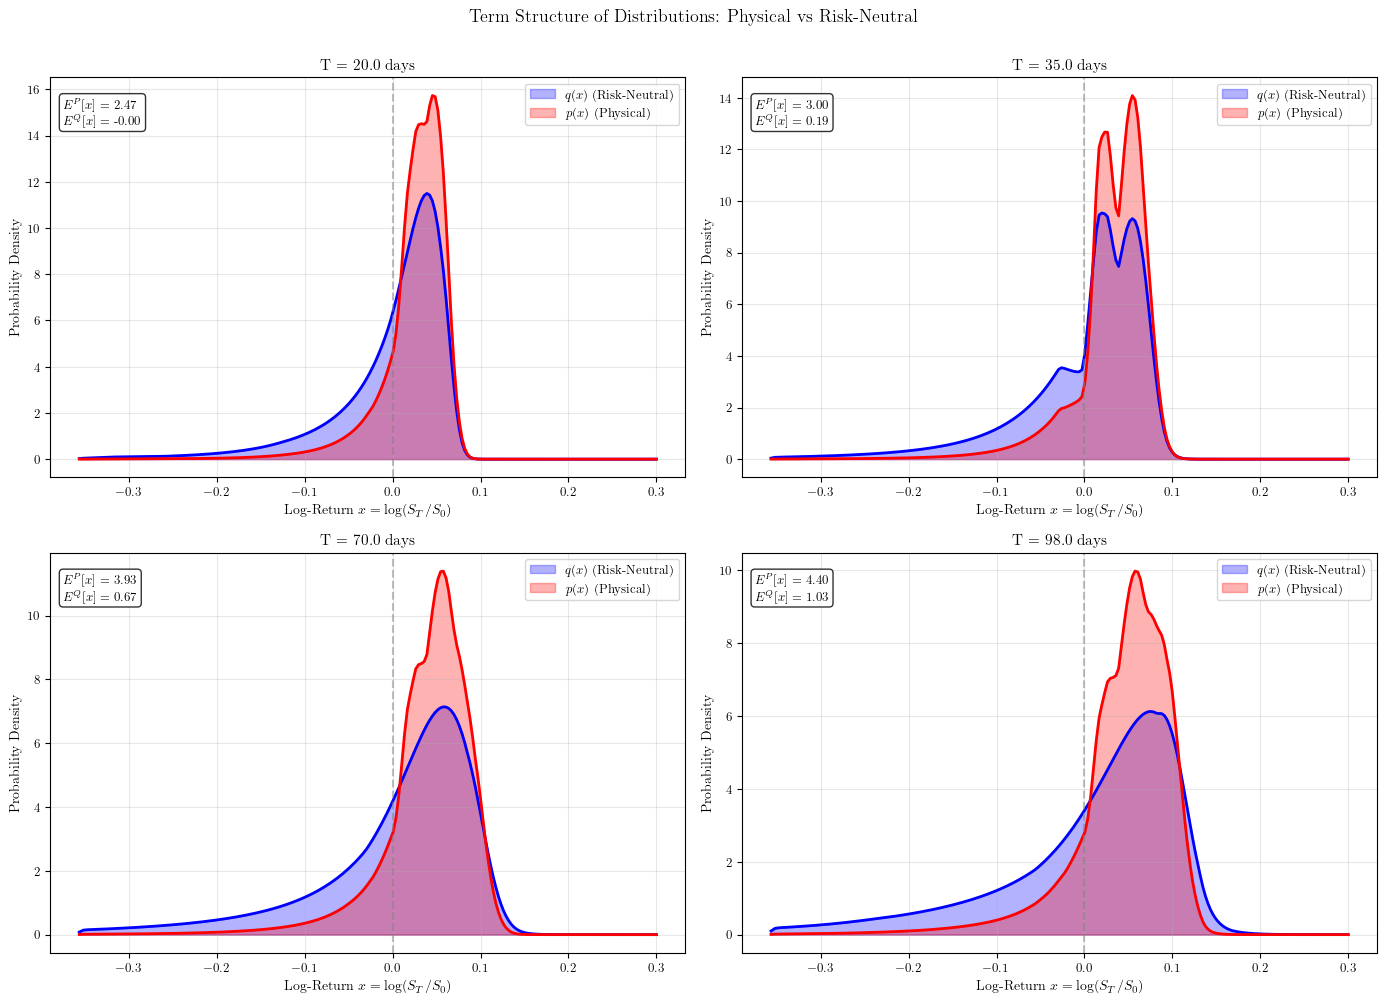

Saved: C:\Users\rafae\Desktop\phd paper\output\fig4_term_structure.pdf


In [13]:
# FIGURE 4: DISTRIBUTIONS ACROSS ALL MATURITIES (Term Structure)
# =============================================================================
# Shows how physical (P) vs risk-neutral (Q) distributions evolve with time horizon

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

log_returns = np.log(moneyness_grid)
dS = S_grid[1] - S_grid[0]

for idx, dte in enumerate(dtes_sorted):
    ax = axes[idx]
    
    # Extract state prices for this maturity
    T = dte / 365.0
    pi_state = state_prices_dict[dte]
    discount_factor = np.exp(-risk_free_rate * T)
    
    # Convert state prices to risk-neutral probabilities
    q_rn_unnorm = pi_state * dS / discount_factor
    q_rn_normalized = q_rn_unnorm / np.sum(q_rn_unnorm)
    
    # Physical measure (using same pricing kernel phi)
    p_phys_unnorm = q_rn_normalized / phi_normalized
    p_phys_unnorm = np.maximum(p_phys_unnorm, 1e-12)
    p_phys = p_phys_unnorm / np.sum(p_phys_unnorm)
    
    # Transform to log-return space with Jacobian
    q_rn_logspace = q_rn_normalized * moneyness_grid
    q_rn_logspace = q_rn_logspace / np.trapezoid(q_rn_logspace, log_returns)
    
    p_phys_logspace = p_phys * moneyness_grid
    p_phys_logspace = p_phys_logspace / np.trapezoid(p_phys_logspace, log_returns)
    
    # Plot distributions
    ax.fill_between(log_returns, 0, q_rn_logspace, alpha=0.3, color='blue', label='$q(x)$ (Risk-Neutral)')
    ax.fill_between(log_returns, 0, p_phys_logspace, alpha=0.3, color='red', label='$p(x)$ (Physical)')
    ax.plot(log_returns, q_rn_logspace, 'b-', linewidth=2)
    ax.plot(log_returns, p_phys_logspace, 'r-', linewidth=2)
    
    ax.axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Log-Return $x = \log(S_T/S_0)$', fontsize=10)
    ax.set_ylabel('Probability Density', fontsize=10)
    ax.set_title(f'T = {dte:.1f} days', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_p = np.trapezoid(p_phys_logspace * log_returns, log_returns)
    mean_q = np.trapezoid(q_rn_logspace * log_returns, log_returns)
    ax.text(0.02, 0.95, f'$E^P[x]$ = {mean_p*100:.2f}%\n$E^Q[x]$ = {mean_q*100:.2f}%', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Term Structure of Distributions: Physical vs Risk-Neutral', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig4_term_structure.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "fig4_term_structure.pdf"}')

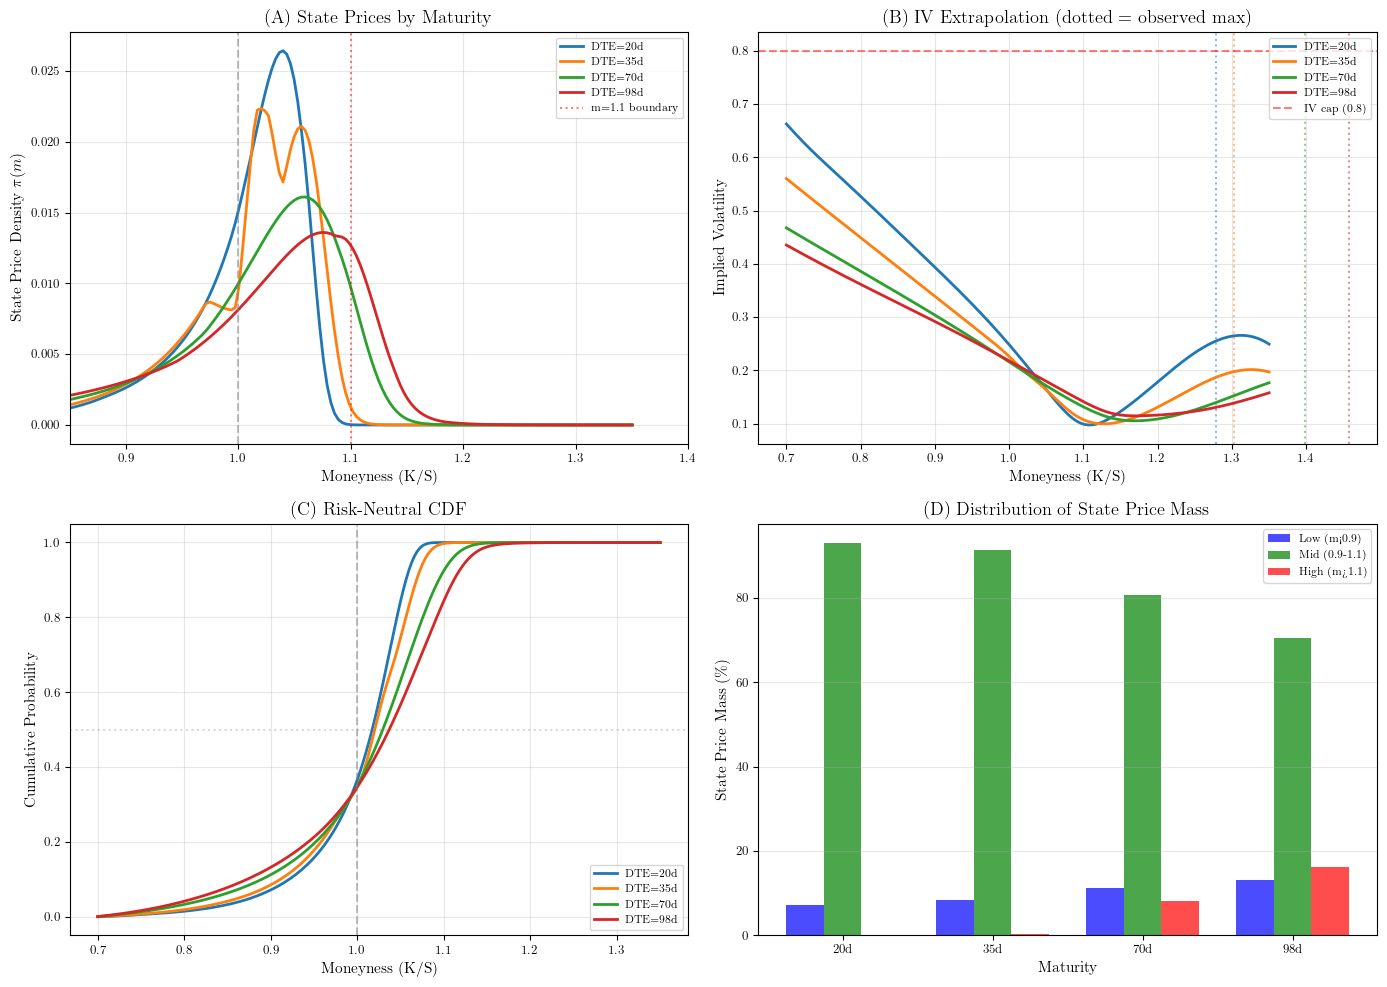

Saved: C:\Users\rafae\Desktop\phd paper\output\fig5_diagnostic.pdf


In [22]:
# FIGURE 5: DIAGNOSTIC - State Price Distribution by Maturity
# =============================================================================
# This figure shows WHY the short maturity has large E^Q[x]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: State prices in price space
ax = axes[0, 0]
for i, dte in enumerate(dtes_sorted):
    pi = state_prices_dict[dte]
    ax.plot(moneyness_grid, pi, label=f'DTE={dte:.0f}d', linewidth=2)
ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=1.1, color='red', linestyle=':', alpha=0.5, label='m=1.1 boundary')
ax.set_xlabel('Moneyness (K/S)')
ax.set_ylabel(r'State Price Density $\pi(m)$')
ax.set_title('(A) State Prices by Maturity')
ax.legend(loc='upper right', fontsize=8)
ax.set_xlim([0.85, 1.4])
ax.grid(True, alpha=0.3)

# Panel B: IV extrapolation (the source of the problem)
ax = axes[0, 1]
m_fine = np.linspace(0.7, 1.35, 200)
K_fine = m_fine * spot_price
for i, dte in enumerate(dtes_sorted):
    iv_fit = np.clip(iv_splines[dte](K_fine), 0.05, 0.8)
    ax.plot(m_fine, iv_fit, label=f'DTE={dte:.0f}d', linewidth=2)
    # Mark observed data range
    smile = iv_smiles[dte]
    m_obs_max = smile['STRIKE'].max() / spot_price
    ax.axvline(x=m_obs_max, color=plt.cm.tab10(i), linestyle=':', alpha=0.5)
ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='IV cap (0.8)')
ax.set_xlabel('Moneyness (K/S)')
ax.set_ylabel('Implied Volatility')
ax.set_title('(B) IV Extrapolation (dotted = observed max)')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

# Panel C: Cumulative state price mass
ax = axes[1, 0]
for i, dte in enumerate(dtes_sorted):
    pi = state_prices_dict[dte]
    cdf = np.cumsum(pi) * dS
    cdf = cdf / cdf[-1]  # Normalize to 1
    ax.plot(moneyness_grid, cdf, label=f'DTE={dte:.0f}d', linewidth=2)
ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)
ax.set_xlabel('Moneyness (K/S)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(C) Risk-Neutral CDF')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

# Panel D: State price mass distribution bar chart
ax = axes[1, 1]
mass_data = []
for dte in dtes_sorted:
    pi = state_prices_dict[dte]
    low_mask = moneyness_grid < 0.9
    mid_mask = (moneyness_grid >= 0.9) & (moneyness_grid <= 1.1)
    high_mask = moneyness_grid > 1.1
    mass_low = np.sum(pi[low_mask]) * dS
    mass_mid = np.sum(pi[mid_mask]) * dS
    mass_high = np.sum(pi[high_mask]) * dS
    total = mass_low + mass_mid + mass_high
    mass_data.append([100*mass_low/total, 100*mass_mid/total, 100*mass_high/total])

x = np.arange(len(dtes_sorted))
width = 0.25
ax.bar(x - width, [m[0] for m in mass_data], width, label='Low (m<0.9)', color='blue', alpha=0.7)
ax.bar(x, [m[1] for m in mass_data], width, label='Mid (0.9-1.1)', color='green', alpha=0.7)
ax.bar(x + width, [m[2] for m in mass_data], width, label='High (m>1.1)', color='red', alpha=0.7)
ax.set_xlabel('Maturity')
ax.set_ylabel('State Price Mass (\%)')
ax.set_title('(D) Distribution of State Price Mass')
ax.set_xticks(x)
ax.set_xticklabels([f'{dte:.0f}d' for dte in dtes_sorted])
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')



plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig5_diagnostic.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR / "fig5_diagnostic.pdf"}')